In [1]:
import pandas as pd
from src.config.settings import settings
from pathlib import Path
from src.data_pulling.read_data import load_and_concat_parquet_files

In [2]:


train_data = Path(settings.RAW_DATA_DIRECTORY) / "train"
test_data = Path(settings.RAW_DATA_DIRECTORY) / "test"

train_df = load_and_concat_parquet_files(train_data)
test_df = load_and_concat_parquet_files(test_data)

In [3]:
train_df.head(2)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
0,2,2024-01-01 00:57:55,2024-01-01 01:17:43,1.0,1.72,1.0,N,186,79,2,17.7,1.0,0.5,0.00,0.0,1.0,22.70,2.5,0.0
1,1,2024-01-01 00:03:00,2024-01-01 00:09:36,1.0,1.80,1.0,N,140,236,1,10.0,3.5,0.5,3.75,0.0,1.0,18.75,2.5,0.0


We can do two models here  
    - `duration`  
    - `amount of money`  
But will start of duration model

In [4]:
train_df['VendorID'].value_counts()

VendorID
2    4506016
1    1465874
6        260
Name: count, dtype: int64

Looks reasonable distribution.  
Let's look at location codes `PULocationID` and `DOLocationID`, which is pick up and drop off location ids respectively

In [5]:
train_df['PULocationID'].nunique(), train_df['DOLocationID'].nunique()

(261, 261)

In [6]:
train_df['PULocationID'] = train_df['PULocationID'].astype(str)
train_df['DOLocationID'] = train_df['DOLocationID'].astype(str)

In [7]:
train_df['PU_DO'] = train_df['PULocationID'] + "_" + train_df['DOLocationID']

- we have created this much location
- We can try later to keep each column as it's and encode it.

In [8]:
# we have created this much location
train_df['PU_DO'].nunique()

32457

In [9]:
train_df.isna().sum()

VendorID                      0
tpep_pickup_datetime          0
tpep_dropoff_datetime         0
passenger_count          325772
trip_distance                 0
RatecodeID               325772
store_and_fwd_flag       325772
PULocationID                  0
DOLocationID                  0
payment_type                  0
fare_amount                   0
extra                         0
mta_tax                       0
tip_amount                    0
tolls_amount                  0
improvement_surcharge         0
total_amount                  0
congestion_surcharge     325772
Airport_fee              325772
PU_DO                         0
dtype: int64

In [10]:
140162 / train_df.shape[0]

0.023469269860937853

<Axes: >

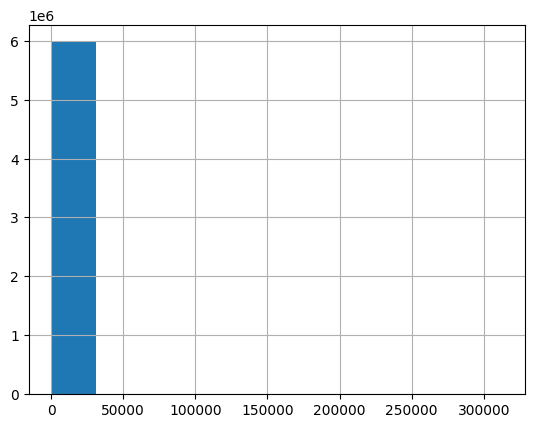

In [11]:
train_df['trip_distance'].hist()

In [12]:
train_df['trip_distance'].quantile(1)

np.float64(312722.3)

In [15]:
from src.features.feature_pipeline import FeatureEngineer
numerical = ["trip_distance"]
categorical = ["PU_DO"]
target = "duration"

preprocessor = FeatureEngineer()
# Use Polars for scalability becasue each month has like 2.5 - 3 Million records!

# Train and test df assumed to be loaded
X_train, y_train = preprocessor.fit_transform(train_df)
X_test, y_test = preprocessor.transform(test_df)

INFO:src.features.feature_pipeline:Fitting and transforming training data...
INFO:src.features.feature_pipeline:Dropping rows with missing airport fee...
INFO:src.features.feature_pipeline:Converting pickup and dropoff datetime columns...
INFO:src.features.feature_pipeline:Calculating trip duration in minutes...
INFO:src.features.feature_pipeline:Filtering out trips with invalid durations...
INFO:src.features.feature_pipeline:Creating PU_DO categorical feature...
INFO:src.features.feature_pipeline:Sorting dataframe by pickup datetime...
INFO:src.features.feature_pipeline:Training data transformation complete.
INFO:src.features.feature_pipeline:Transforming new data...
INFO:src.features.feature_pipeline:Dropping rows with missing airport fee...
INFO:src.features.feature_pipeline:Converting pickup and dropoff datetime columns...
INFO:src.features.feature_pipeline:Calculating trip duration in minutes...
INFO:src.features.feature_pipeline:Filtering out trips with invalid durations...
INFO:

In [18]:
X_train.shape, X_test.shape

((5633435, 29248), (3146858, 29248))

In [20]:
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import r2_score, mean_squared_error

In [21]:
lr_model = LinearRegression()
xgb_model = XGBRegressor()
catboost_model = CatBoostRegressor(iterations=300, verbose=0, allow_writing_files=False)
lgbm_model = LGBMRegressor()

In [22]:
lr_model.fit(X_train, y_train)
preds = lr_model.predict(X_test)
rmse = mean_squared_error(y_test, preds) ** 1 / 2
r2 = r2_score(y_test, preds)
rmse, r2

(22.261348506810982, 0.7249909895528694)

In [23]:
xgb_model.fit(X_train, y_train)
preds = xgb_model.predict(X_test)
rmse = mean_squared_error(y_test, preds) ** 1 / 2
r2 = r2_score(y_test, preds)
rmse, r2

(22.495584688752583, 0.7220973166656693)

In [24]:
lgbm_model.fit(X_train, y_train)
preds = lgbm_model.predict(X_test)
rmse = mean_squared_error(y_test, preds) ** 1 / 2
r2 = r2_score(y_test, preds)
rmse, r2

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013663 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 17765
[LightGBM] [Info] Number of data points in the train set: 5633435, number of used features: 8756
[LightGBM] [Info] Start training from score 14.844049


d:\Github Repos\Taxi-Duration-Prediction\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


(22.425198521507042, 0.7229668430646401)

In [ ]:
catboost_model.fit(X_train, y_train)
preds = catboost_model.predict(X_test)
rmse = mean_squared_error(y_test, preds) ** 1 / 2
r2 = r2_score(y_test, preds)
rmse, r2

(23.295308613214505, 0.7122178035252196)